In [18]:
import torch
import random
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [19]:
# read all words

words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [20]:
len(words)

32033

Vocab

In [21]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [22]:
block_size = 3

def build_dataset(words):

    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] #crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train, Y_train = build_dataset(words[:n1])
X_dev, Y_dev = build_dataset(words[n1:n2])
X_test, Y_test = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [23]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):    
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        #parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        #buffers (trained with running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        #forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        #update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum * self.running_var) + self.momentum * xvar

        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:

    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [29]:
n_embed = 10 #dim of the char embeddings
n_hidden = 100 #num of neurons in the hidden layer of MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator=g)

layers = [

    Linear(n_embed * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    #make last layer less confident
    layers[-1].weight *= 0.1
    #for all other layers apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


46497


In [30]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #minibatch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ), generator=g)
    Xb, Yb = X_train[ix], Y_train[ix] #batch X, Y

    #forward pass
    emb = C[Xb] #embed the characters into vectors
    x = emb.view(emb.shape[0], -1)

    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    #backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    #learning rate
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay

    #update
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.2962


1 Tanh tensor(-0.0234, grad_fn=<MeanBackward0>) tensor(0.7498, grad_fn=<StdBackward0>) tensor(20.2500)
3 Tanh tensor(-0.0029, grad_fn=<MeanBackward0>) tensor(0.6864, grad_fn=<StdBackward0>) tensor(8.3750)
5 Tanh tensor(0.0013, grad_fn=<MeanBackward0>) tensor(0.6732, grad_fn=<StdBackward0>) tensor(6.6250)
7 Tanh tensor(-0.0060, grad_fn=<MeanBackward0>) tensor(0.6569, grad_fn=<StdBackward0>) tensor(5.4688)
9 Tanh tensor(-0.0207, grad_fn=<MeanBackward0>) tensor(0.6626, grad_fn=<StdBackward0>) tensor(6.1250)


Text(0.5, 1.0, 'activation distribution')

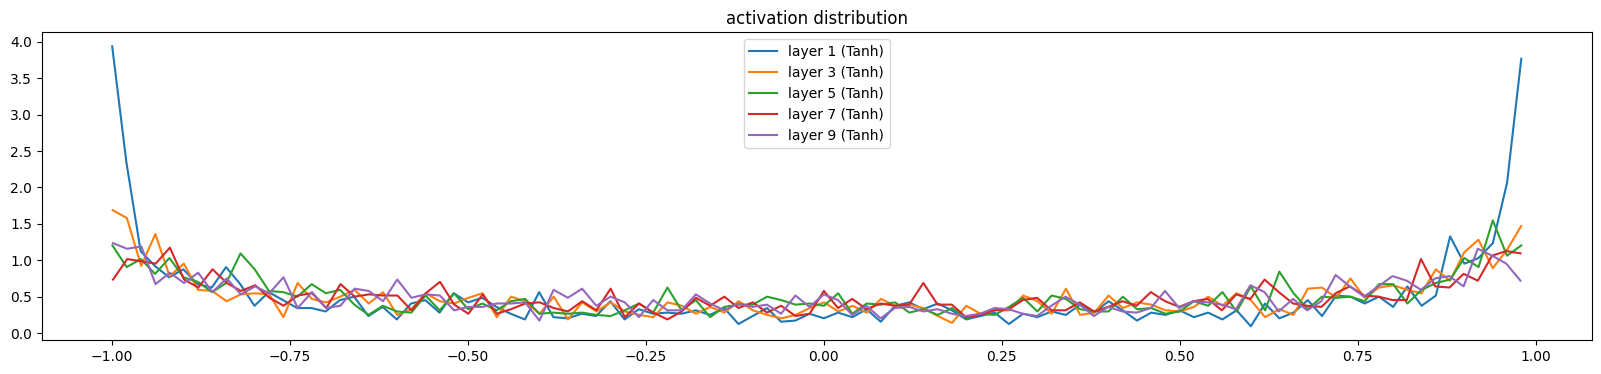

In [31]:
#visualize hist
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100)
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

- Experiment with different gain values and see if how these dist change
- If gain is 1, tanh keeps squashing the outputs and they approach zero

1 Tanh tensor(1.0004e-05) tensor(0.0004) tensor(0.)
3 Tanh tensor(-3.4323e-06) tensor(0.0004) tensor(0.)
5 Tanh tensor(3.0796e-06) tensor(0.0004) tensor(0.)
7 Tanh tensor(1.5073e-05) tensor(0.0003) tensor(0.)
9 Tanh tensor(-1.3680e-05) tensor(0.0003) tensor(0.)


Text(0.5, 1.0, 'gradient distribution')

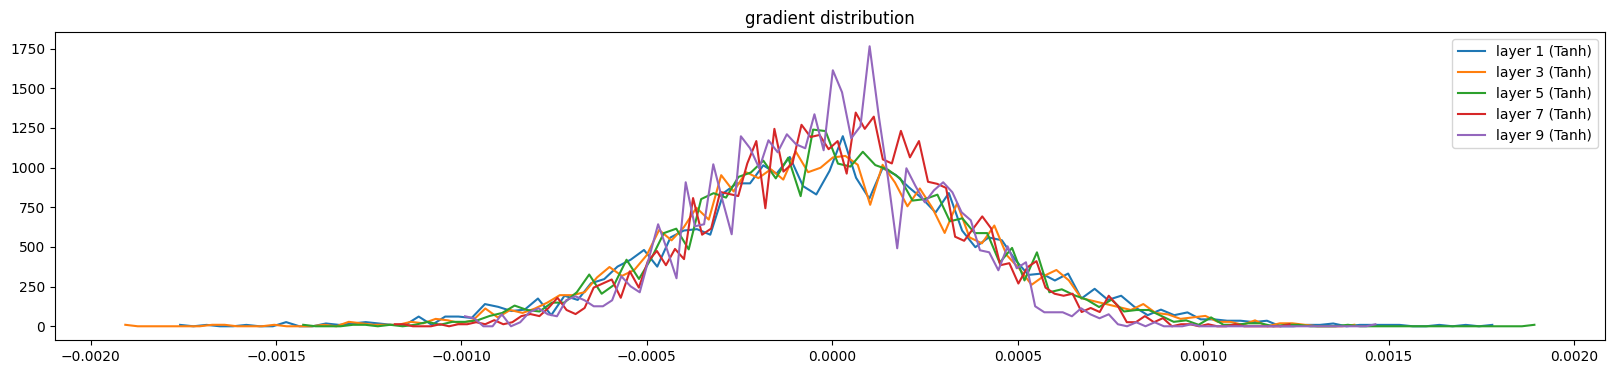

In [32]:
#visualize hist
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100)
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

(27, 10) tensor(-3.0730e-05) tensor(0.0014) tensor(0.0014, grad_fn=<DivBackward0>)
(30, 100) tensor(-4.9288e-05) tensor(0.0012) tensor(0.0039, grad_fn=<DivBackward0>)
(100, 100) tensor(1.6358e-05) tensor(0.0011) tensor(0.0066, grad_fn=<DivBackward0>)
(100, 100) tensor(-1.0099e-05) tensor(0.0010) tensor(0.0059, grad_fn=<DivBackward0>)
(100, 100) tensor(-1.1118e-05) tensor(0.0009) tensor(0.0052, grad_fn=<DivBackward0>)
(100, 100) tensor(-4.1436e-06) tensor(0.0007) tensor(0.0044, grad_fn=<DivBackward0>)
(100, 27) tensor(-8.0025e-11) tensor(0.0236) tensor(2.3282, grad_fn=<DivBackward0>)


Text(0.5, 1.0, 'gradient distribution')

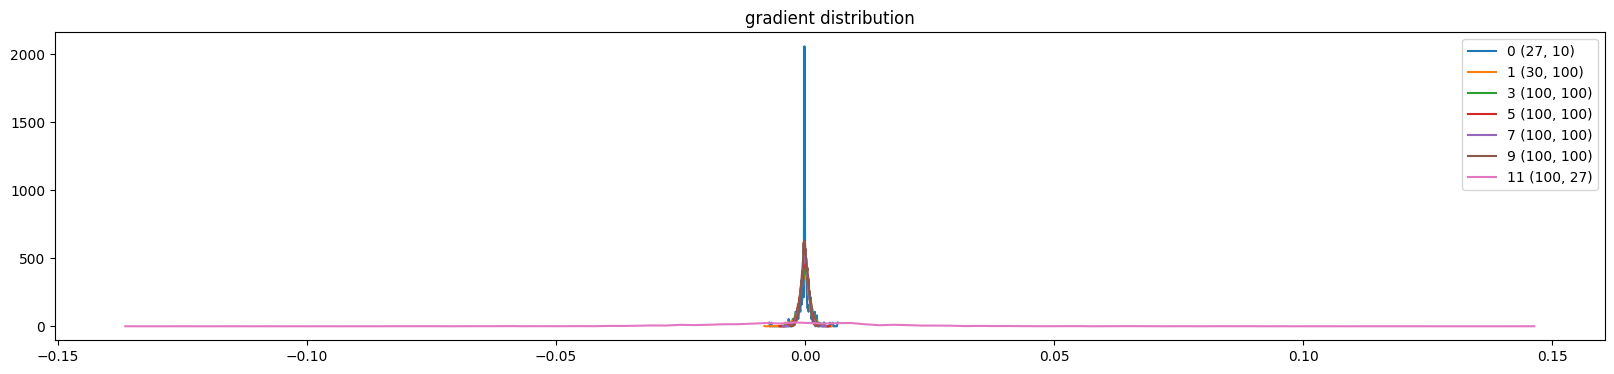

In [34]:
#visualize hist
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(tuple(p.shape), t.mean(), t.std(), t.std()/p.std())
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('gradient distribution')